## Installing and Importing packages

In [ ]:
!pip install pmdarima optuna

In [ ]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import yfinance as yf

import pandas_datareader as pdr
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [ ]:
data = yf.download('AAPL', start='2021-01-01', end='2023-12-31')

# data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'],inplace=True)

# Checking the data
# stock_data.to_csv('stock.csv', index=True)

num_days_pred=30 # Number of days you want to predict in the future the higher the less accuracy




def mean_squared_error(y_true, y_pred):
    """Calculates MSE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) ** 2)

def add_lags(df, num_days_pred):
    """
    Add lag features to the dataframe based on the specified number of prediction days.
    """
    df = df.copy()
    targets = ['Close','Open', 'High', 'Low', 'Adj Close', 'Volume']
    for i in range(1, 13):
        for target in targets:
            df[f'{target}lag{i}'] = df[target].shift(num_days_pred * i)
    return df


def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# add_lags(data,1).to_csv('after_lag.csv', index=True)

## XGBOOST

In [ ]:
xgb_data = add_lags(data,1)
xgb_data = create_features(xgb_data)
xgb_data.to_csv('xgb_before.csv', index=True)
xgb_data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'],inplace=True)
xgb_data.to_csv('xgb_afer.csv', index=True)
X = xgb_data.drop(columns='Close')
y = xgb_data['Close']

In [ ]:


# Define objective function for Optuna
objective = lambda trial: np.sqrt(
    mean_squared_error(
        y_test,
        (xgb := XGBRegressor(
            objective='reg:squarederror',
            eval_metric='rmse',
            n_estimators=trial.suggest_int('n_estimators', 100, 1000),
            max_depth=trial.suggest_int('max_depth', 3, 10),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.1),
            subsample=trial.suggest_float('subsample', 0.6, 1.0),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
            reg_alpha=trial.suggest_float('reg_alpha', 0, 10),
            reg_lambda=trial.suggest_float('reg_lambda', 0, 10),
            verbosity=0
        )).fit(X_train, y_train).predict(X_test)
    )
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = xgb_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)


[I 2024-04-22 00:57:10,726] A new study created in memory with name: no-name-076fb363-1e9a-482e-9667-0050ad84492b
[I 2024-04-22 00:57:37,642] Trial 0 finished with value: 2.9449056718790017 and parameters: {'n_estimators': 806, 'max_depth': 6, 'learning_rate': 0.08754145672701062, 'subsample': 0.6490396049646778, 'colsample_bytree': 0.8859268354591803, 'reg_alpha': 4.798592217538637, 'reg_lambda': 1.749531596875541}. Best is trial 0 with value: 2.9449056718790017.
[I 2024-04-22 00:57:44,154] Trial 1 finished with value: 2.862410659301201 and parameters: {'n_estimators': 248, 'max_depth': 10, 'learning_rate': 0.0884570078870919, 'subsample': 0.6272549879342026, 'colsample_bytree': 0.6319576968500403, 'reg_alpha': 3.1067717224245026, 'reg_lambda': 7.4849780993888775}. Best is trial 1 with value: 2.862410659301201.
[I 2024-04-22 00:57:49,074] Trial 2 finished with value: 2.839764926747004 and parameters: {'n_estimators': 317, 'max_depth': 6, 'learning_rate': 0.09207764544791579, 'subsampl

Best trial:
  Value: 2.6995356427961608
  Params: 
    n_estimators: 901
    max_depth: 9
    learning_rate: 0.010321181512941126
    subsample: 0.7812915961209171
    colsample_bytree: 0.6531104345784535
    reg_alpha: 8.059847168840516
    reg_lambda: 0.41716851209254635
Test RMSE: 2.6995356427961608


In [ ]:
y_pred_test_xgb = xgb_best.predict(X_test)
xgb_loss = mean_squared_error(y_test, y_pred_test_xgb)
print(f"MEAN SQUARED ERROR = { mean_squared_error(y_test, y_pred_test_xgb) }")

MEAN SQUARED ERROR = 7.287492686726881


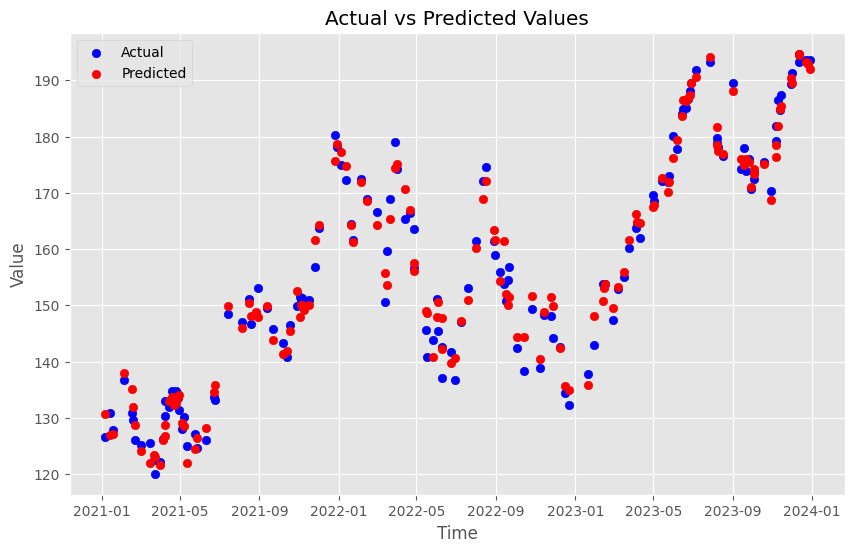

In [ ]:
# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot actual values
ax.scatter(X_test.index, y_test, color='blue', label='Actual')

# Plot predicted values
ax.scatter(X_test.index, y_pred_test_xgb, color='red', label='Predicted')

# Set title and labels
ax.set_title('Actual vs Predicted Values')
ax.set_xlabel('Time')
ax.set_ylabel('Value')

# Add a legend
ax.legend()

# Display the plot
plt.show()

## Neural Network

In [117]:
# nn_data = data.copy()
nn_data = add_lags(data,1)
nn_data = nn_data[12:]
nn_data = create_features(nn_data)
nn_data.to_csv('nn_before.csv', index=True)
nn_data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'],inplace=True)
nn_data.to_csv('nn_after.csv', index=True)
# X = nn_data.drop(columns='Close')
# X.to_csv('X.csv', index=True)

# y = nn_data['Close']
# y.to_csv('y.csv', index=True)

# nn_data.head()

from sklearn.preprocessing import StandardScaler
# Dropping non-numerical and the target column 'Close' from features
features = nn_data.drop([ 'Close'], axis=1)



# Target variable
target = nn_data['Close']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

X_train = X_train[[f'Closelag{i}' for i in range(1,13)]]
X_test = X_test[[f'Closelag{i}' for i in range(1,13)]]

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [123]:


from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# # Defining the neural network using MLPRegressor
# mlp_model = MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam',
#                          max_iter=500, random_state=42)

# # Training the model
# mlp_model.fit(X_train_scaled, y_train)

# # Predicting on the test set
# y_pred = mlp_model.predict(X_test_scaled)

# # Calculating the mean squared error on the test set
# mse = mean_squared_error(y_test, y_pred)
# mse

from sklearn.model_selection import GridSearchCV

# Defining the parameter grid
param_grid = {
    'hidden_layer_sizes': [(128, 64, 32), (100, 50), (50, 25, 10)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [500,1000,2000,5000]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(MLPRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Perform grid search
grid_search.fit(X_train_scaled, y_train)

# Best parameters found
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert from negative MSE to positive MSE

best_params, best_score


Fitting 3 folds for each of 240 candidates, totalling 720 fits
({'activation': 'relu',
  'hidden_layer_sizes': (100, 50),
  'learning_rate_init': 0.001,
  'max_iter': 1000,
  'solver': 'adam'},
 7.455469315558434)


In [119]:
from sklearn.neural_network import MLPRegressor

# Define the parameters
parameters = {
    'activation': 'relu',
    'hidden_layer_sizes': (100, 50),
    'learning_rate_init': 0.001,
    'max_iter': 1000,
    'solver': 'adam'
}

# Initialize the MLPRegressor model with the specified parameters
mlp_regressor = MLPRegressor(**parameters)

# Train the model with your training data
mlp_regressor.fit(X_train_scaled, y_train)  # Replace X_train and y_train with your training data

# Optionally, you can make predictions using the trained model
y_pred_test = mlp_regressor.predict(X_test_scaled)  # Replace X_test with your test data


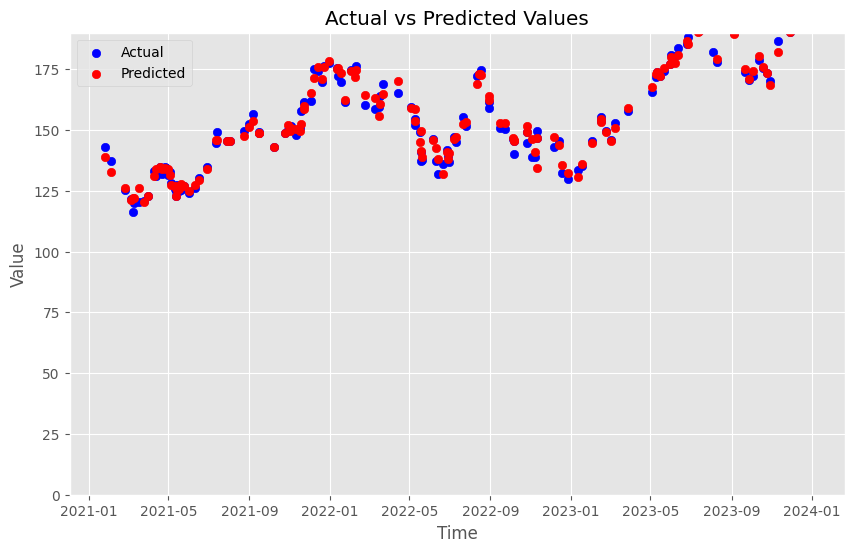

In [120]:
# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot actual values
ax.scatter(X_test.index, y_test, color='blue', label='Actual')

# Plot predicted values
ax.scatter(X_test.index, y_pred_test, color='red', label='Predicted')

# Set title and labels
ax.set_title('Actual vs Predicted Values')
ax.set_xlabel('Time')
ax.set_ylabel('Value')

# Add a legend
ax.legend()
plt.ylim(top=190, bottom=0)  # Set the maximum y-axis value to 20

# Display the plot
plt.show()

In [122]:
print(f'MSE = {mean_squared_error(y_pred_test, y_test)}')

MSE = 8.418908754879107


## Prophet

In [ ]:
prophet_data = data.copy()
prophet_data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'],inplace=True)

prophet_data.head()

,Close
Date,
2021-01-04,129.410004
2021-01-05,131.009995
2021-01-06,126.599998
2021-01-07,130.919998
2021-01-08,132.050003


In [ ]:
train_size = 0.8

# Split the data into training and testing sets based on the defined proportion
train_prophet, test_prophet = train_test_split(prophet_data, train_size=train_size, shuffle=False)
train_prophet = train_prophet.reset_index().rename(columns={'Date':'ds','Close':'y'})
test_prophet

,Close
Date,
2023-05-25,172.990005
2023-05-26,175.429993
2023-05-30,177.300003
2023-05-31,177.250000
2023-06-01,180.089996
...,...
2023-12-22,193.600006
2023-12-26,193.050003
2023-12-27,193.149994


In [ ]:
prophet = Prophet()
prophet.fit(train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfix0_2cy/tlu48zze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfix0_2cy/q7vjp5az.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93436', 'data', 'file=/tmp/tmpfix0_2cy/tlu48zze.json', 'init=/tmp/tmpfix0_2cy/q7vjp5az.json', 'output', 'file=/tmp/tmpfix0_2cy/prophet_modellh5n163v/prophet_model-20240422015643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:56:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:56:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
test_prophet = test_prophet.reset_index().rename(columns={'Date':'ds','Close':'y'})
test_predict = prophet.predict(test_prophet)
test_prophet

,ds,y
0,2023-05-25,172.990005
1,2023-05-26,175.429993
2,2023-05-30,177.300003
3,2023-05-31,177.250000
4,2023-06-01,180.089996
...,...,...
146,2023-12-22,193.600006
147,2023-12-26,193.050003
148,2023-12-27,193.149994
149,2023-12-28,193.580002


In [ ]:
porphet_loss = mean_squared_error(test_prophet['y'],test_predict['yhat'] )
print(f"MSE = { mean_squared_error(test_prophet['y'],test_predict['yhat'] ) }")

MSE = 378.24109195597305


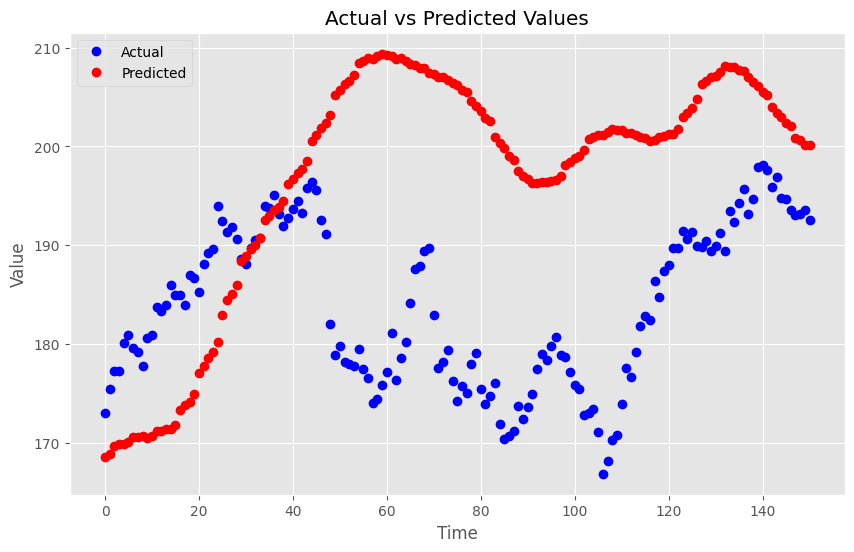

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(test_prophet.index, test_prophet['y'], 'bo', label='Actual')

# Plot predicted values
plt.plot(test_prophet.index, test_predict['yhat'], 'ro', label='Predicted')

plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


## Arima

In [ ]:
arima_data = data.copy()
arima_data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'],inplace=True)
arima_data

,Close
Date,
2021-01-04,129.410004
2021-01-05,131.009995
2021-01-06,126.599998
2021-01-07,130.919998
2021-01-08,132.050003
...,...
2023-12-22,193.600006
2023-12-26,193.050003
2023-12-27,193.149994


In [ ]:
train_size = 0.8

# Split the data into training and testing sets based on the defined proportion
train_arima, test_arima = train_test_split(arima_data, train_size=train_size, shuffle=False)
test_arima

,Close
Date,
2023-05-25,172.990005
2023-05-26,175.429993
2023-05-30,177.300003
2023-05-31,177.250000
2023-06-01,180.089996
...,...
2023-12-22,193.600006
2023-12-26,193.050003
2023-12-27,193.149994


In [ ]:
# Try to find the best parameters for arima model
stepwise_fit = auto_arima(train_arima['Close'],trace=True,suppress_warnings=True)
# assign the parameter to "best_order" variable
best_order = stepwise_fit.get_params()['order']
arima = ARIMA(train_arima['Close'], order=best_order)
arima = arima.fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2941.090, Time=1.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2938.182, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2940.061, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2940.041, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2936.570, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2940.619, Time=0.73 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.223 seconds


In [112]:
# Determine the number of steps to forecast
steps_to_forecast = len(test_arima)

# Use the forecast method to predict future values
pred_arima = arima.forecast(steps=steps_to_forecast)


<Axes: xlabel='Date'>

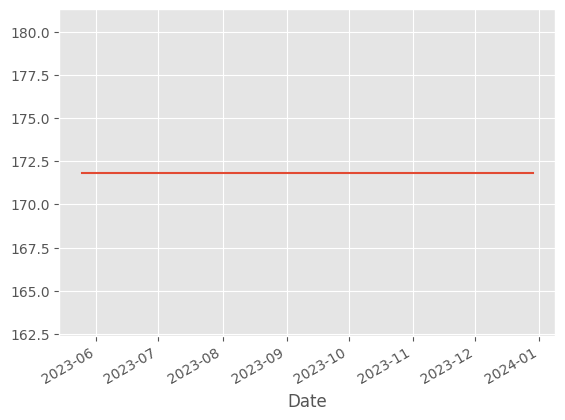

In [113]:
pred_arima.index = test_arima.index
pred_arima.plot()

In [115]:
arima_loss = mean_squared_error(test_arima['Close'],pred_arima )
print(f"MSE = { mean_squared_error(test_arima['Close'],pred_arima ) } ")

MSE = 208.10660468163863 
